In [1]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista
from typing import List, Tuple
from src.visualization import timeDependentVariableToGif, printControlFunction, plot_array
from src.solveStateEquation import solveStateEquation, getSourceTerm
from src.solveAdjointEquation import solveAdjointEquation
from src.tools import getValueOfFunction
from src.ExtremalPoints import ExtremalPoint
from dataclasses import dataclass
from mystic import solvers

In [2]:
@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)   
    area = 4
    d = 2
    alpha = 2.2
    beta = 2.53
    waveSpeed = 1
    randomFactor = 0.05
    solverIteration = 0
    
params = Parameters()

## Solving the state equation

In [3]:
msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((-1.0, -1.0), (1.0, 1.0)),
    n=(32, 32),
    cell_type=mesh.CellType.triangle,
)

V = fem.functionspace(msh, ("Lagrange", 1))

s1 = lambda t : 1 #0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))
s2 = lambda t : 0 #0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))

g1 = getSourceTerm(V, params.x1, params)
g2 = getSourceTerm(V, params.x2, params)

K_u, u = solveStateEquation(V, [g1, g2], [s1, s2], params)

#timeDependentVariableToGif(K_u, filename="solution.gif", varname="solution", slowMoFactor=2, T=T)
#timeDependentVariableToGif(u, filename="control.gif", varname="control", slowMoFactor=2, T=T)

## Calculate dual variables $\bar{p}$ and $\bar{P}$

In [4]:
grid_size = K_u[0].x.array.shape

# Creating the measured state
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)

phi = [fem.Function(V) for _ in K_u]
for idx in range(len(phi)):
    phi[idx].x.array[:] = 0 * K_u[idx].x.array - yd[idx].x.array
    
adjointState = solveAdjointEquation(V, phi, params)

#timeDependentVariableToGif(yd, filename="adjoint.gif", varname="adjoint", slowMoFactor=2, T=T)

adjointValues = np.ndarray((len(adjointState), params.d), dtype=np.float64)
for idx, func in enumerate(adjointState):
    adjointValues[idx] = getValueOfFunction(V, func, [params.x1, params.x2])[:, 0]

first_dual = np.zeros((len(adjointState), params.d), dtype=np.float64)
first_dual[0] = adjointValues[0]
for idx in range(1, len(adjointState)):
    first_dual[idx] = first_dual[idx - 1] + adjointValues[idx]
first_dual /= (len(adjointState) - 1)

second_dual = np.zeros((len(adjointState), params.d), dtype=np.float64)
second_dual[0] = first_dual[0]
for idx in range(1, len(adjointState)):
    second_dual[idx] = second_dual[idx - 1] + first_dual[idx]
second_dual /= (len(adjointState) - 1)

#plot_array(np.linalg.norm(first_dual, axis=1), params.T)
#plot_array(np.linalg.norm(second_dual, axis=1), params.T)

idx_xS = np.argmax(np.linalg.norm(first_dual, axis=1))
idx_xK = np.argmax(np.linalg.norm(second_dual, axis=1))

sigma_xS = first_dual[idx_xS] / np.linalg.norm(first_dual[idx_xS])
sigma_xK = second_dual[idx_xK] / np.linalg.norm(second_dual[idx_xK])

#test = fem.Function(V)
#test.interpolate(lambda x:  np.sqrt(x[0]**2 + x[1]**2))
#print(getValueOfFunction(V, test, [(1-0.001, 0), (0.5,0.5)]))

## Initial iterative method

In [8]:
params.solverIteration = 0

def buildIterationFunction(t, active_set, weights: np.ndarray, slope: np.ndarray, y_shift: np.ndarray, params):
	value = np.zeros_like(slope)
	for idx, func in enumerate(active_set):
		value += weights[idx] * func.value(t)
	return_value = value + np.array(slope) * t + np.array(y_shift)
	return return_value

def calculateDiscreteGradient(V, u, yd, params):
	s1 = lambda t: u(t)[0]
	s2 = lambda t: u(t)[1]
	
	g1 = getSourceTerm(V, params.x1, params)
	g2 = getSourceTerm(V, params.x2, params)
	K_u, control = solveStateEquation(V, [g1, g2], [s1, s2], params)
	phi = [fem.Function(V) for _ in K_u]
	for idx in range(len(phi)):
		phi[idx].x.array[:] = 0 * K_u[idx].x.array - yd[idx].x.array
		
	adjointState = solveAdjointEquation(V, phi, params)

	adjointValues = np.ndarray((len(adjointState), params.d), dtype=np.float64)
	for idx, func in enumerate(adjointState):
		adjointValues[idx] = getValueOfFunction(V, func, [params.x1, params.x2])[:, 0]
	return adjointValues

def integrateVectorFunction(function, params):
	integrated_function = np.zeros((len(function), params.d), dtype=np.float64)
	integrated_function[0] = function[0]
	for idx in range(1, len(function)):
		integrated_function[idx] = integrated_function[idx - 1] + function[idx]
	integrated_function /= (len(function) - 1)
	return integrated_function
	
def pruneActiveSet(active_set, weights):
	new_active_set = []
	new_weights = []
	for idx, func in enumerate(active_set):
		if weights[idx] > 0.1:
			new_active_set.append(func)
			new_weights.append(weights[idx])
	return new_active_set, np.array(new_weights)

def finDimObjective(weights, slope, y_shift, params, active_set, yd):
	u = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)

	s1 = lambda t: u(t)[0]
	s2 = lambda t: u(t)[1]
	
	g1 = getSourceTerm(V, params.x1, params)
	g2 = getSourceTerm(V, params.x2, params)
	K_u, control = solveStateEquation(V, [g1, g2], [s1, s2], params)
	params.solverIteration += 1
	print(params.solverIteration)
	phi = [fem.Function(V) for _ in K_u]
	for idx in range(len(phi)):
		phi[idx].x.array[:] = K_u[idx].x.array - yd[idx].x.array
	squared = np.zeros_like(phi[0].x.array)
	for func in phi:
		squared += np.sqrt(func.x.array)
	squared /= params.T/params.dt
	return (0.5 * np.sqrt(np.mean(squared)) + np.sum(weights))
	
def getIdxMax(value_array, active_set, type):
    exept_idcs = [func.idx for func in active_set if func.type == type]
    print('exept indices: ', exept_idcs)
    norm_array = np.linalg.norm(value_array, axis=1)
    mask = np.zeros(norm_array.size, dtype=bool)
    mask[exept_idcs] = True
    clean_array = np.ma.array(norm_array, mask=mask)
    if clean_array.size == 0:
        return -1
    idx = np.argmax(clean_array)
    return idx

def solveFinDimProblem(weights, slope, y_shift, params, active_set, yd, solverSteps=0):
	x0 = np.zeros(len(active_set) + 2 * params.d)
	x0[:len(active_set) - 1] = weights
	x0[len(active_set) - 1] = 0.5
	x0[-2*params.d:-params.d] = slope
	x0[-params.d:] = y_shift
	bounds = []
	for _ in range(len(active_set)):
		bounds.append((0, np.inf))
	for _ in range(2 * params.d):
		bounds.append((-np.inf, np.inf))
	cost = lambda x: finDimObjective(x[:len(active_set)], x[-2*params.d:-params.d], x[-params.d:], params, active_set, yd)
	solution = solvers.fmin(cost, x0=x0, bounds=bounds, maxiter=10, maxfun=100)
	params.solverIterations = 0
	new_weights = solution[:len(active_set)]
	new_slope = solution[-2*params.d:-params.d]
	new_y_shift = solution[-2:]
	return new_weights, new_slope, new_y_shift

active_set = []
max_iteration = 10
N = 2
active_set.append(ExtremalPoint(np.array([1.0, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt)))
active_set.append(ExtremalPoint(np.array([1.0, 0]), 0.7, type=1, params=params, idx=int(0.7/params.dt)))

weights = np.ones(len(active_set) - 1)
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))

# TODO: Newton method calculate weights, slope, y_shift as minimum to f(u(active_set, weights, slope, y_shift)) + sum(weights)
weights, slope, y_shift = solveFinDimProblem(weights, slope, y_shift, params, active_set, yd)

for k in range(max_iteration):
	print('Iteration ', k)
	u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
	
	# Calculate dual variables
	gradIn_u_k = calculateDiscreteGradient(V, u_k, yd, params)
	p = integrateVectorFunction(gradIn_u_k, params)
	P = integrateVectorFunction(p, params)
	
	idx_xS = getIdxMax(p, active_set, type=0)
	print('Jump indices: ', [func.idx for func in active_set if func.type == 0])
	print('Jump weights:', [weights[idx] for idx in range(len(active_set)) if active_set[idx].type == 0])
	idx_xK = getIdxMax(P, active_set, type=1)
	print('Kink indices: ', [func.idx for func in active_set if func.type == 1])
	print('Kink weights:', [weights[idx] for idx in range(len(active_set)) if active_set[idx].type == 1])

	p_max = np.linalg.norm(p[idx_xS])
	P_max = np.linalg.norm(p[idx_xK])
	
	#if (max(p_max / alpha, P_max / beta) <= 1):
	#    break
	# Add new extremal point to the active set
	if (p_max / params.alpha > P_max / params.beta):
		active_set.append(ExtremalPoint(p[idx_xS] / p_max, idx_xS * params.dt, type=0, params=params, idx=idx_xS))
	else:
		active_set.append(ExtremalPoint(P[idx_xK] / P_max, idx_xK * params.dt, type=1, params=params, idx=idx_xK))
	
	# TODO: Newton method calculate weights, slope, y_shift as minimum to f(u(active_set, weights, slope, y_shift)) + sum(weights)   
	weights, slope, y_shift = solveFinDimProblem(weights, slope, y_shift, params, active_set, yd)

	# Prune extremal points which are not used
	active_set, weights = pruneActiveSet(active_set, weights)
	
	
print('Procedure stopped after ', k + 1, ' iterations')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
Iteration  0
exept indices:  [50]
Jump indices:  [50]
Jump weights: [1.0]
exept indices:  [70]
Kink indices:  [70]
Kink weights: [0.5]
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
Iteration  1
exept indices:  [50, 100]
Jump indices:  [50, 100]
Jump weights: [1.0, 0.5]
exept indices:  [70]
Kink indices:  [70]
Kin

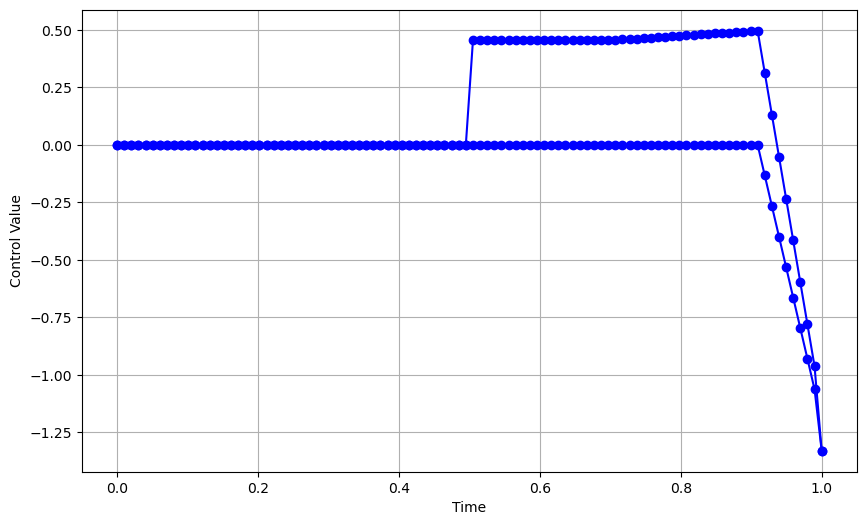

0 sigma:  [1. 0.] x0:  0.5 weight:  1.0
1 sigma:  [1. 0.] x0:  0.7 weight:  0.5
2 sigma:  [-0.81099675 -0.58505066] x0:  1.0 weight:  0.5
3 sigma:  [-0.81124843 -0.58470162] x0:  0.99 weight:  0.5
4 sigma:  [-0.81124835 -0.58470173] x0:  0.98 weight:  0.5
5 sigma:  [-0.81124809 -0.5847021 ] x0:  0.97 weight:  0.5
6 sigma:  [-0.81124758 -0.5847028 ] x0:  0.96 weight:  0.5
7 sigma:  [-0.81124672 -0.58470399] x0:  0.9500000000000001 weight:  0.5
8 sigma:  [-0.81124542 -0.5847058 ] x0:  0.9400000000000001 weight:  0.5
9 sigma:  [-0.81124358 -0.58470835] x0:  0.93 weight:  0.5
10 sigma:  [-0.81124112 -0.58471176] x0:  0.92 weight:  0.5
11 sigma:  [-0.81123795 -0.58471615] x0:  0.91 weight:  0.5


In [9]:
timepoints = np.linspace(0, params.T, int(params.T / params.dt))
array = np.array([u_k(t) for t in timepoints])
mpl.pyplot.figure(figsize=(10, 6))
mpl.pyplot.plot(timepoints, array, marker='o', linestyle='-', color='b')
mpl.pyplot.xlabel('Time')
mpl.pyplot.ylabel('Control Value')
mpl.pyplot.grid(True)
mpl.pyplot.show()

for idx, extremalPoint in enumerate(active_set):
    print(idx, 'sigma: ', extremalPoint.sigma, 'x0: ', extremalPoint.x_0, 'weight: ', weights[idx])